This dataset is predicting rental bike count
-

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy
import seaborn as sns 
import tensorflow as tf
from sklearn.linear_model import LinearRegression 



In [55]:
# Creating a scalar function
def scale_dataset(dataframe, oversample = False):
    # Grabbing all of the columns except the last one since that is our label
    X = dataframe[dataframe.columns[:-1]].values
    
    # Grabbing our label column
    y = dataframe[dataframe.columns[-1]].values

    # Creating a scalar object
    scaler = StandardScaler()

    # Fitting the x valuues to the standard scaler. Then transforms all of the 
    # values based on that
    X = scaler.fit_transform(X)

    # If we want to oversample, create an oversample object and fit_transform the data to it.
    # All its doing is taking more of the less class
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    # Creating a 2-D numpy array to return. hstack grabs two arrays and stacks them
    # together horizontally. Numpy is particular about shapes so we have to use the 
    # .reshape method to make the 1-by-1 array (y) a 2-by-1 array. Important, the 
    # -1 tells numpy to infer the shape!
    dataset = np.hstack((X, np.reshape(y, (-1, 1))))

    return dataset, X, y


Importing and Cleaning up the data for analysis

In [56]:
# Creating a variable list that will be the columns header
datasetCols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]


# Reading in the data into a pandas dataframe and drop some unwanted columns
data = pd.read_csv('SeoulBikeData.csv', encoding = 'unicode_escape').drop(['Date', 'Holiday', 'Seasons'], axis=1)

# Setting the column names to how we want it
data.columns = datasetCols

# Converting the language/strings over to a number
data['functional']= (data['functional'] == 'Yes').astype(int)

# Indexing to a certain hour for the sake of this analysis. Then dropping the hour column since dataset is only 12th hour
data = data[data['hour'] == 12].drop(['hour'], axis = 1)



data.head(10)


,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1
132,405,2.4,52,0.9,1224,-6.4,1.08,0.0,0.0,1
156,431,3.7,65,2.4,833,-2.2,0.98,0.0,0.3,1
180,355,-2.0,30,1.4,1728,-17.3,1.14,0.0,0.0,1
204,427,2.4,40,0.8,1809,-9.8,1.05,0.0,0.0,1
228,119,2.3,88,0.3,245,0.5,0.28,0.0,3.1,1


Plotting the scatters for all of these

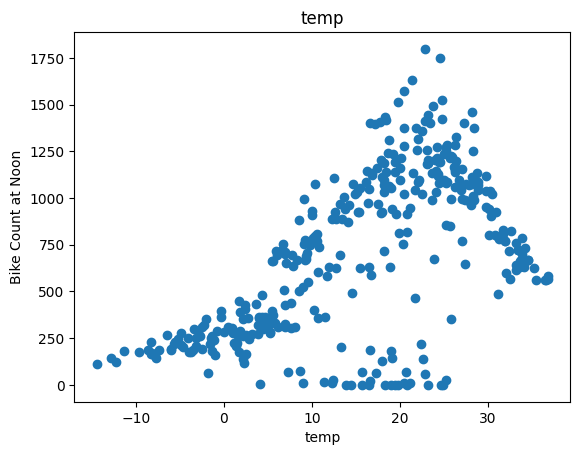

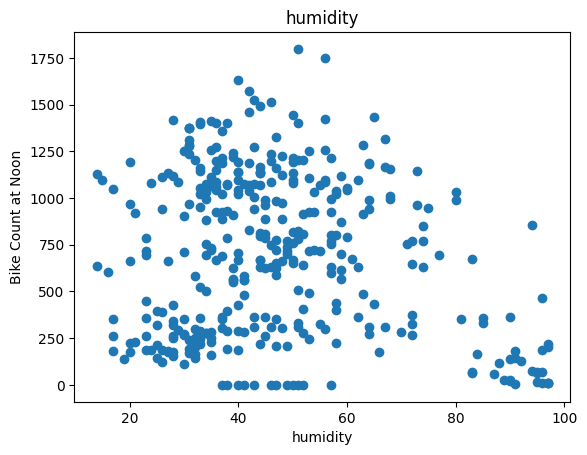

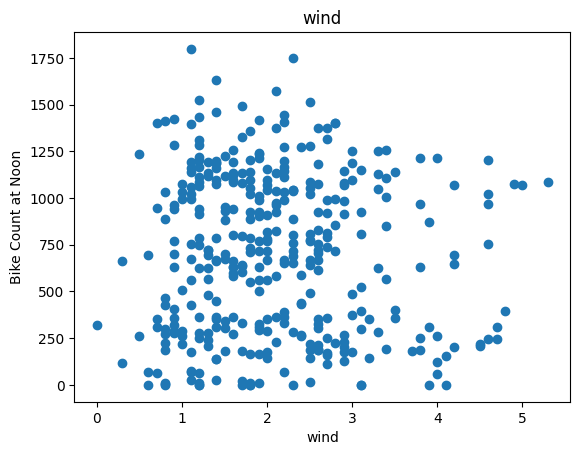

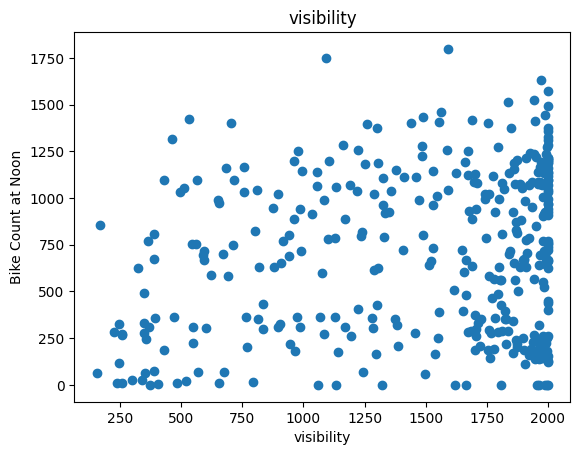

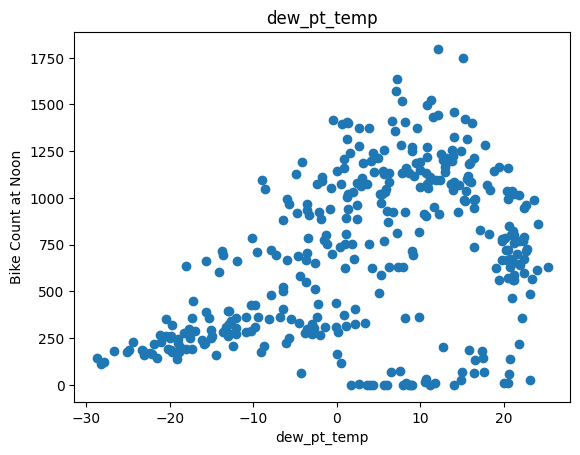

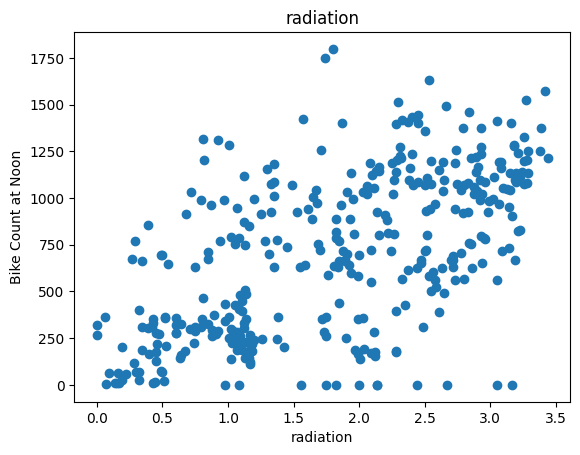

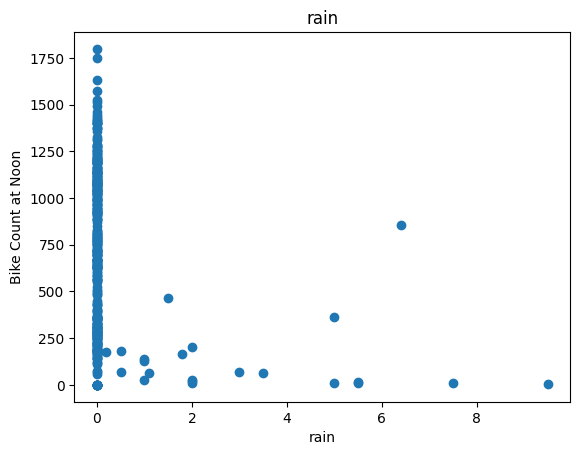

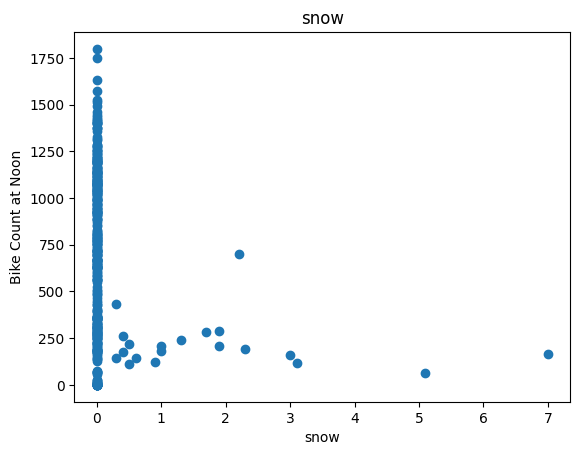

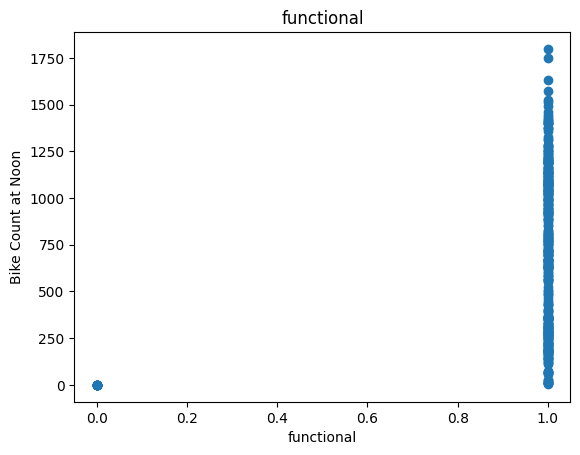

In [57]:
for label in data.columns[1:]:
    # Looking at how the data affects the bike count
    plt.scatter(data[label], data['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

In [58]:
# After looking at all of the graphs, choose the ones that seem to have no/minimal affect on bike count
data = data.drop(['wind', 'visibility', 'functional'], axis = 1)

In [59]:
data

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...,...
8652,752,9.1,57,1.0,1.69,0.0,0.0
8676,672,9.3,61,2.1,0.85,0.0,0.0
8700,635,7.9,14,-18.0,1.81,0.0,0.0
8724,661,5.6,27,-11.9,0.34,0.0,0.0


Splitting up dataset train/valid/test

In [60]:
# THis is where we split the dataset up. Splitting the dataframe into three sections. We
# first randomize the entire dataframe then split the first 60% into training, 20% into validation
# and 20% into test
train, valid, test = np.split(data.sample(frac= 1), [int(0.6 * len(data)), int(0.8*len(data))])



 Linear Regression
-

- Linear Regression is an algorithm that finds the line of best fit that best models the data
- We're trying to predict Y based off a given X value that we haven't seen yet, some continuous numerical value for Y
- Want to fit a linear model to our data, the line's equation is y = b0 + b1*x, this is Simple Linear Regression.
- Multiple Linear Regression is for when we have more than one x, so think of all of the feature vectors. So our predictor will look more like b0 +b1x1 + b2x2
- Reminder, we need to have 4 assumptions: Linearity, independence, normality and homoskedasticity
- Linearity: the data has to follow a linear pattern. Example of nonlinear would be when a line of best fit is some kind of curve. 
- Independence: each data point should NOT have an effect on another data point. Each sample should be independent.
- Normality: uses the residual plot. We plot all of the errors and looking for residuals that are normally distributed around the line of best fit
- Homoskedasticity: uses the residual plot. After all errors are plotted, it is looking for a constant VARIANCE between residuals

Concept of Residual/Error
-

- Residual/error is how we evaluate how far off the prediction (yHat) is from a data point that we already have (y)
- Residual is the absolute value of the difference between yHat and y (|y8 - yHat|)
- The line of best fit is trying its best to decrease the residuals as much as possible, so we are trying to minimize the sum of all the residuals
- Sometimes we have to square the sum of all the residuals, this adds a higher penalty for how far off we are from points that are further off. The spreading of points must be constant

![Screenshot (30).png](<attachment:Screenshot (30).png>)

![Screenshot (32).png](<attachment:Screenshot (32).png>)

Evaluating Linear Regression Models
-

1. Mean Absolute Error (MAE)
- Taking all of the errors/residuals and sums up the distance for all of them and then take the average of those. Is the average distance between the predicted value and the actual value
- Allows us to directly compare to whatever value the Y-axis' unit is in. So average MAE in $ makes sense when looking at price of houses. 

2. Mean Squared Error (MSE)
- Similar idea to MAE except instead of taking the absolute values of the residuals, we are squaring them.
- This measure is used to punish large errors in the prediction and later on may be more important due to differentiability. 
- Harder to compare the values to the Y axis

3. Root Mean Squared Error (RMSE)
- Similar to MSE but we take a huge square root over everything at the end. 
- This brings the units back to real world applications

4. R-squared: Coefficient of Determination (there is also adjusted R-squared)
- We need the sum of the squared residuals (RSS)
- We need the total sum of squares (TSS). Instead of the predictions, we take our y value and subtract it by the MEAN of the y value
- TSS: Can take the average of all y values with no regressor and try to predict that average Y. This means y and x may not be associated with each other at all. With respect to that average, what is our error. That is TSS
- If the line of best fit is a better fit pthan the total sum of squares (TSS) then that means our numerator will be smaller than our denominator. So we want our R-squared to be SMALL and goes towards 1. The closer we are to 1 the better sign it is that it is a good predictor
- Adjusted R-squared adjusts for all of the extra terms (x1, x2, x3)


Creating a function to grab our x's and y's. Remember that the data has been broken up already so we can't just splice the original dataset. This is for each subset we created (train, test, valid)

In [61]:
# This function will create a deep copy of our dataframe
def getXY(dataframe, yLabel, x_Labels = None):
    dataframe = copy.deepcopy(dataframe)

    if x_Labels == None:
        x = dataframe[[c for c in dataframe.columns if c != yLabel]].values
    else:
        if len(x_Labels) == 1:
            x = dataframe[x_Labels[0]].values.reshape(-1,1)
        else:
            x = dataframe[x_Labels].values

    y = dataframe[yLabel].values.reshape(-1,1)

    # Horizontally stacking the two datasets together
    data = np.hstack((x, y))

    return data, x, y

Applying the function out

In [62]:
# yTrainTemp is the associated bike_counts
_, xTrainTemp, yTrainTemp = getXY(train, 'bike_count', x_Labels= ['temp'])

In [63]:
_, xValTemp, yValTemp = getXY(valid, 'bike_count', x_Labels= ['temp'])
_, xTestTemp, yTestTemp = getXY(test, 'bike_count', x_Labels= ['temp'])

Training the model

In [64]:
tempRegression = LinearRegression()
tempRegression.fit(xTrainTemp, yTrainTemp)

LinearRegression()

Printing model's intercepts and coefficients

In [65]:
print(tempRegression.coef_, tempRegression.intercept_)

[[22.94392385]] [356.59759729]


Getting our r-squared for the model. 0 means no association, 1 means strong association

In [66]:
tempRegression.score(xTestTemp, yTestTemp)

0.27207976631763153

Did a one-dimensional linear regression model to show it off

Text(0.5, 0, 'Temperature')

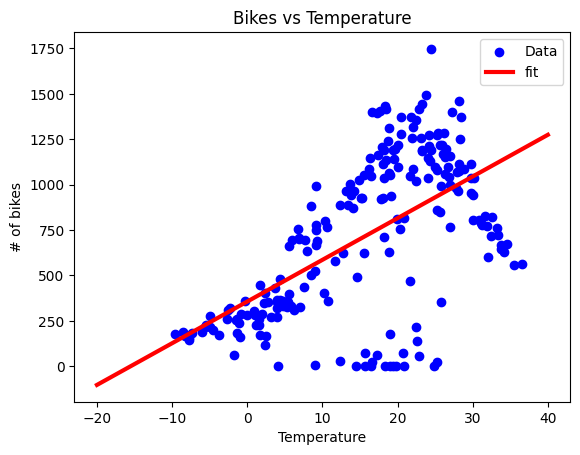

In [67]:
plt.scatter(xTrainTemp, yTrainTemp, label = 'Data', color = 'blue')
x = np.linspace(-20, 40, 100)
# Remember .reshape(-1, 1) tells the system to infer the correct shape
plt.plot(x, tempRegression.predict(np.array(x).reshape(-1, 1)), label = 'fit', color = 'red', linewidth = 3)
plt.legend()
plt.title('Bikes vs Temperature')
plt.ylabel('# of bikes')
plt.xlabel('Temperature')

In [68]:
data.columns[1:]

Index(['temp', 'humidity', 'dew_pt_temp', 'radiation', 'rain', 'snow'], dtype='object')

Multiple Linear Regression
-

In [69]:
# Splitting the data
train, valid, test = np.split(data.sample(frac= 1), [int(0.6 * len(data)), int(0.8*len(data))])

_, xTrainAll, yTrainAll = getXY(train, 'bike_count', x_Labels= data.columns.tolist()[1:])
_, xValAll, yValAll = getXY(valid, 'bike_count', x_Labels= data.columns.tolist()[1:])
_, xTestAll, yTestAll = getXY(test, 'bike_count', x_Labels= data.columns.tolist()[1:])

In [70]:
# Creating and training the model
allReg = LinearRegression()
allReg.fit(xTrainAll, yTrainAll)

LinearRegression()

In [71]:
# Scoring our model, getting the r-squared score
allReg.score(xTestAll, yTestAll)

0.5012897217633783

Can actually do Regression with a Neural Net
-

- Typically helps to normalize our data before using with Tensorflow and can easily do so with tensorflow

In [72]:
# Normalizing the data
tempNormalizer = tf.keras.layers.Normalization(input_shape = (1,), axis = None)
tempNormalizer.adapt(xTrainTemp.reshape(-1))


Then we can use a single neuron for our regressions. A singular dense layer with one single unit is saying that it is linear and no activation functions make it linear

In [73]:
# Building the model with a single layer
tempNNModel = tf.keras.Sequential([tempNormalizer,
                     tf.keras.layers.Dense(1)
                     ])

In [75]:
# Compiling the model
tempNNModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [76]:
# Grabbing the accuracy/performance of the model
history = tempNNModel.fit(xTrainTemp.reshape(-1), yTrainTemp, 
                          verbose= 0, 
                          epochs = 1000, 
                          validation_data=  (xValTemp, yValTemp)
                          )

In [77]:
# Plotting performance of the model
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

This is a pretty good plot, the values are converging

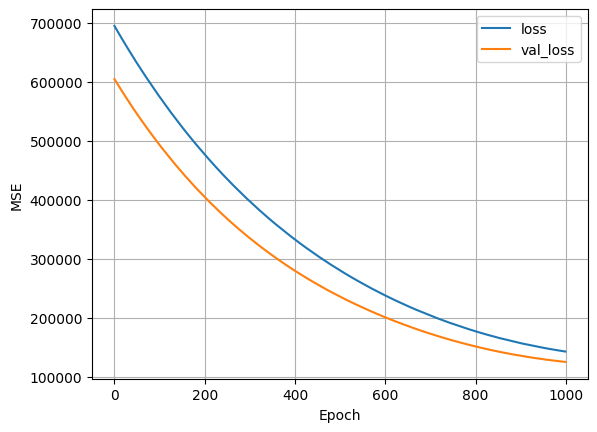

In [78]:
plot_loss(history)

Now showing our new linear regression based off of the neural net model, uses a different method (uses backpropogation) to get to the linear regression line

4/4 [==============================] - 0s 1ms/step


Text(0.5, 0, 'Temperature')

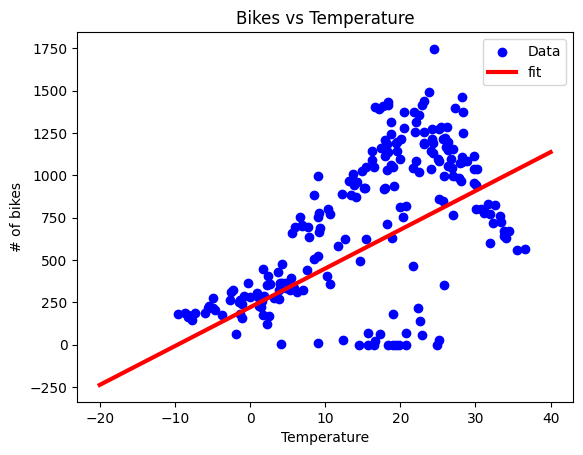

In [79]:
plt.scatter(xTrainTemp, yTrainTemp, label = 'Data', color = 'blue')
x = np.linspace(-20, 40, 100)
# Remember .reshape(-1, 1) tells the system to infer the correct shape
plt.plot(x, tempNNModel.predict(np.array(x).reshape(-1, 1)), label = 'fit', color = 'red', linewidth = 3)
plt.legend()
plt.title('Bikes vs Temperature')
plt.ylabel('# of bikes')
plt.xlabel('Temperature')

Using a neural net with more than one node
-

In [81]:
# Creating a neural net with the same normalizer
# Building the model with a single layer
tempNNModel = tf.keras.Sequential([tempNormalizer,
                     tf.keras.layers.Dense(32, activation= 'relu'),
                     tf.keras.layers.Dense(32, activation= 'relu'),
                     tf.keras.layers.Dense(1, activation= 'relu')
                     ])

tempNNModel.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001), loss= 'mean_squared_error')

In [ ]:
history= tempNNModel.fit(
    xTrainTemp, yTrainTemp,
    validation_data = (xValTemp, yValTemp),
    verbose = 0, epochs = 100
)